<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Supervised/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Voice Gender Classifier
Goal: Build a model to predict the speaker’s gender (male/female) using acoustic voice
features.

In [1]:
!pip install pandas scikit-learn seaborn matplotlib

 Load the Voice Gender Dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("primaryobjects/voicegender")

print("Path to dataset files:", path)

100%|██████████| 405k/405k [00:00<00:00, 76.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/primaryobjects/voicegender/versions/1


In [3]:
import pandas as pd

df = pd.read_csv(path + "/voice.csv")

In [4]:
  # Preview data
print(df.head())

   meanfreq        sd    median       Q25       Q75       IQR       skew  \
0  0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1  0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2  0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3  0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4  0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   

          kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0   274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1   634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2  1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3     4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4     4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   

     maxfun   meandom    mindom    maxdom   dfrange   modindx  label  
0  0.275862  0.007812  0.007812  

Preprocess Data


In [5]:
print(df.isnull().sum())

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64


In [6]:
df['label'] = df['label'].map({'male': 0, 'female': 1})

In [7]:
X = df.drop('label', axis=1)
y = df['label']

Split into Train and Test Sets

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train a Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Evaluate the Model

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9842271293375394

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       337
           1       0.97      0.99      0.98       297

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634



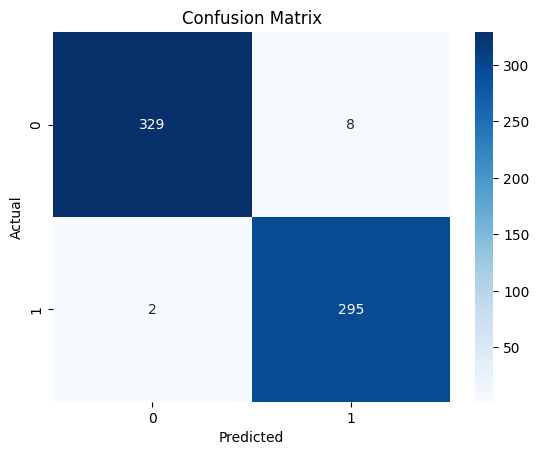

In [11]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance Plot

<Axes: ylabel='None'>

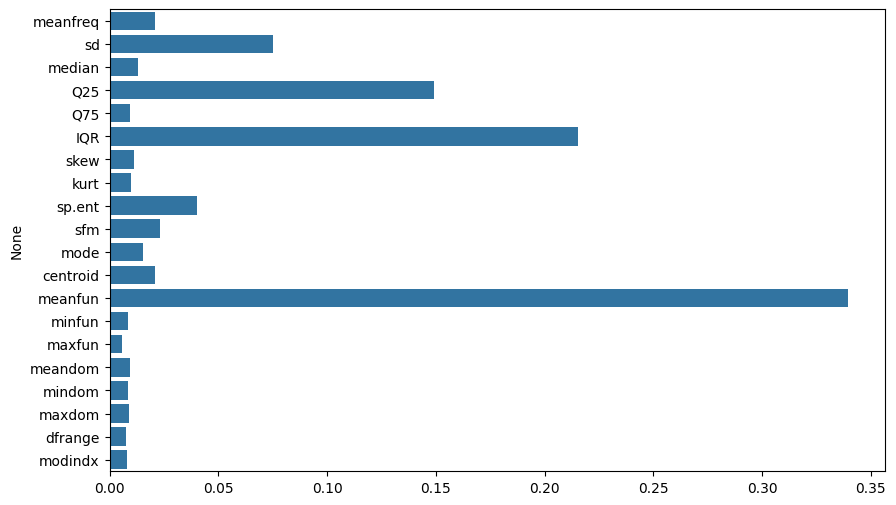

In [12]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)

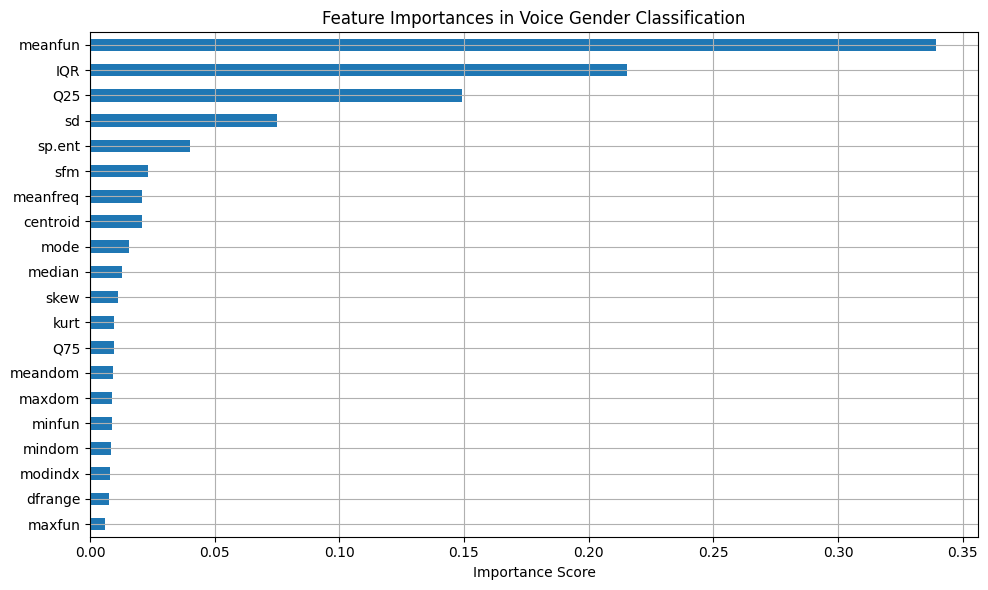

In [14]:
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh')
plt.title("Feature Importances in Voice Gender Classification")
plt.xlabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

# Get the top 10 most important features
top_10_features = feat_imp.nlargest(10).index

# Create new training and testing sets with only the top 10 features
X_train_top10 = X_train[top_10_features]
X_test_top10 = X_test[top_10_features]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top10)
X_test_scaled = scaler.transform(X_test_top10)

# Build the deep learning model
model_dl = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_dl.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Train the model
history = model_dl.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=0)

# Evaluate the model
loss, accuracy = model_dl.evaluate(X_test_scaled, y_test)
print(f"\nDeep Learning Model Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9794 - loss: 0.0497 

Deep Learning Model Accuracy: 0.9794952869415283


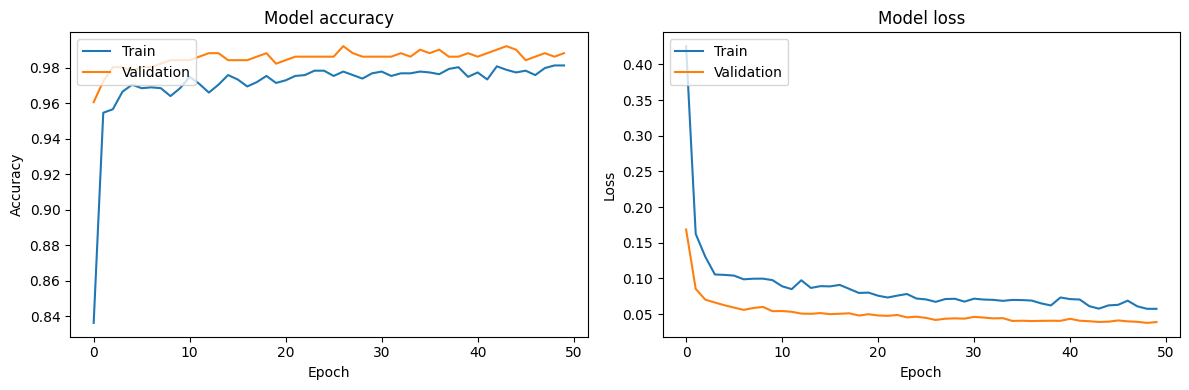

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Adjust regularization and add early stopping



In [17]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Build the regularized deep learning model
model_dl_regularized = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Create an EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile the model
model_dl_regularized.compile(optimizer='adam',
               loss='binary_crossentropy',
               metrics=['accuracy'])

# Train the model
history_regularized = model_dl_regularized.fit(X_train_scaled, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=0)

# Evaluate the model
loss_reg, accuracy_reg = model_dl_regularized.evaluate(X_test_scaled, y_test)
print(f"\nDeep Learning Model with L2 Regularization and Early Stopping Accuracy: {accuracy_reg}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9794 - loss: 0.0753 

Deep Learning Model with L2 Regularization and Early Stopping Accuracy: 0.9794952869415283


## Experiment with a simpler architecture



In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a simpler deep learning model
model_dl_simple = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_dl_simple.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Train the model
history_simple = model_dl_simple.fit(X_train_scaled, y_train,
                                     epochs=50,
                                     batch_size=32,
                                     validation_split=0.2,
                                     verbose=0)

# Evaluate the model
loss_simple, accuracy_simple = model_dl_simple.evaluate(X_test_scaled, y_test)
print(f"\nSimpler Deep Learning Model Accuracy: {accuracy_simple}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9806 - loss: 0.0610 

Simpler Deep Learning Model Accuracy: 0.9779179692268372


## Compare results



Model Performance Comparison:


,Accuracy,Loss
Original DL,0.979495,0.052899
Regularized DL,0.979495,0.078673
Simple DL,0.977918,0.062731


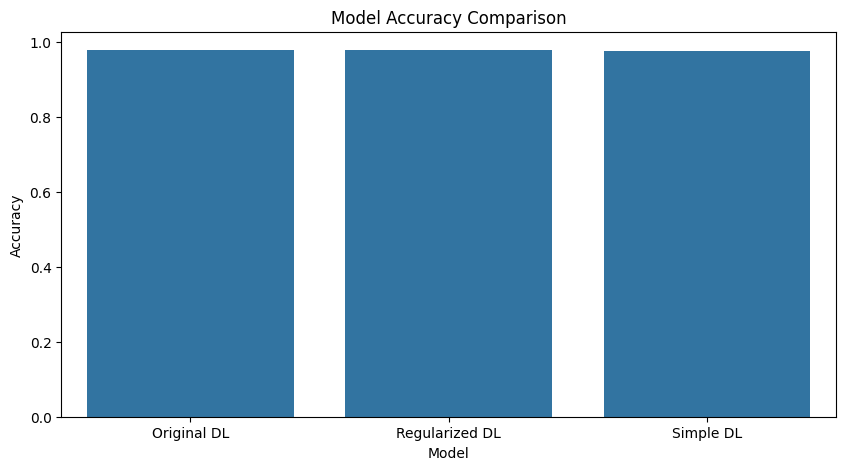

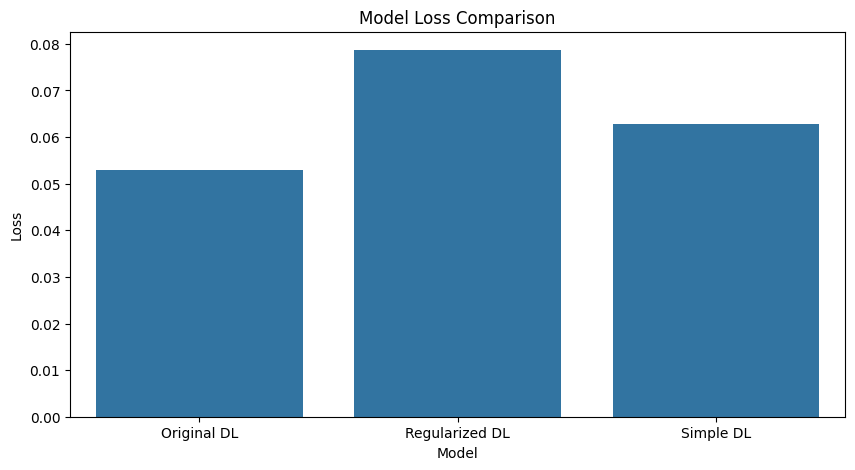

In [19]:
# Create a dictionary to store the model performance
model_performance = {
    "Original DL": {"Accuracy": accuracy, "Loss": loss},
    "Regularized DL": {"Accuracy": accuracy_reg, "Loss": loss_reg},
    "Simple DL": {"Accuracy": accuracy_simple, "Loss": loss_simple}
}

# Create a DataFrame from the dictionary
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')

# Print the DataFrame
print("Model Performance Comparison:")
display(performance_df)

# Create a bar plot for accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x=performance_df.index, y=performance_df['Accuracy'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

# Create a bar plot for loss
plt.figure(figsize=(10, 5))
sns.barplot(x=performance_df.index, y=performance_df['Loss'])
plt.title('Model Loss Comparison')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The Deep Learning Model with L2 Regularization and Early Stopping achieved an accuracy of approximately 97.95% on the test set.
*   The Simpler Deep Learning Model achieved an accuracy of approximately 97.79% on the test set.
*   The Original Deep Learning and Regularized Deep Learning models had the highest accuracy (0.979495), while the Simple Deep Learning model had slightly lower accuracy (0.977918).
*   The Original Deep Learning model had the lowest loss (0.052899), followed by the Simple Deep Learning model (0.062731), and then the Regularized Deep Learning model (0.078673).

### Insights or Next Steps

*   While regularization and early stopping didn't significantly improve accuracy in this case, they are valuable techniques for preventing overfitting, especially with larger datasets or more complex models.
*   The simpler model performed comparably to the more complex models, suggesting that for this specific dataset, a less complex architecture is sufficient and computationally more efficient.
